<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/py_algotrading_force_index_different_periods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading Model using Force Index with Different Periods
### David Lowe
### September 22, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model employs a simple mean-reversion strategy for stock position entries and exits using force index indicators. For the Force Index indicator, the model will use a 13-period and a 50-period indicator for the trading signal. The model will initiate a long position when the trading indicator turns from negative to positive. Conversely, the model will exit the long position when the signal indicator turns from positive to negative.

ANALYSIS: In this modeling iteration, we analyzed ten stocks between August 1, 2016, and September 17, 2021. The models' performance appeared at the end of the script. The models with the wider signal line width generally produced a better return for the tested stocks. Moreover, the simple buy-and-hold approach came out ahead for all stocks.

CONCLUSION: For most stocks during the modeling time frame, the long-only trading strategy with the Force Index did not produce a better return than the buy-and-hold approach. We should consider modeling these stocks further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

### 1.a) Load libraries and modules

In [ ]:
pip install python-dotenv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
# import statistics as stats
from dotenv import load_dotenv

# Begin the timer for the script processing
startTimeScript = datetime.now()

In [ ]:
# Set up access to the dotenv file on local PC
env_path = "C:/Users/cubas/OneDrive/Documents/Github Projects/4 Quantitative Finance Projects/"
dotenv_path = env_path + "python_script.env"
load_dotenv(dotenv_path=dotenv_path)

False

### 1.b) Set up the controlling parameters and functions¶

In [ ]:
# Specify the key modeling parameters below
# stock_list = ['AAPL']
stock_list = ['AAPL','ABBV','AMD','AMZN','BA','DIS','NFLX','GOOGL','JPM','MSFT']

# Specify the parameters for calculating moving average windows
INITIAL_CAPITAL = 100000
TREND_WINDOW = 20
VOLUME_WINDOW = 5

# Specify the parameters for calculating Force Index
MODEL_1_PERIOD = 13
MODEL_2_PERIOD = 50

# Specify the risk management parameters
HOLDING_PERIOD_MIN = 999
HOLDING_PERIOD_MAX = 999
GAIN_MAX = 0.99
LOSS_MAX = 0.99
LONG_ONLY = True  # If false, model both long and short trades

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of window size)
EXTRA_DAYS = 30

MODEL_START_DATE = date(2016, 8, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 9, 17)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 2)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_data_retrieval = True  # Show the head and tail of the raw dataframe
verbose_indicators = True  # All entries from the Indicators dataframe
verbose_signals = True  # All entries from the Signals dataframe
verbose_entry_exit = True  # All entry and exit points from the Signals dataframe
verbose_trade_actions = True  # All bought and sold activities during portfolio generation
verbose_portfolios = True  # All entries from the Positions dataframe
verbose_transactions = True  #  All buying and selling transactions from the Positions dataframe
verbose_draw_graphs = True

Starting date for the model: 2016-08-01
Ending date for the model: 2021-09-17
First date of data we need for modeling: 2016-06-02
Last date of data we need for modeling: 2021-09-17


In [ ]:
# Set up parameters for displaying report data
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 999)
pd.set_option('display.float_format', '{:.4f}'.format)

## Task 2 - Acquire and Pre-Process Data

In [ ]:
pip install quandl

In [ ]:
# Check and see whether the API key is available
import quandl
quandl.ApiConfig.api_key = 'AywUrfKTvTTsCiRfWoWp'
quandl_key = quandl.ApiConfig.api_key
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [ ]:
def retrieve_stock_data(ticker=stock_list[0]):
    if ticker == '':
        sys.exit('Stock symbol not available. Script processing cannot continue!!!')

    start_date_string = data_start_date.strftime('%Y-%m-%d')
    end_date_string = data_end_date.strftime('%Y-%m-%d')
    quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, ticker, quandl_key)
    response = requests.get(quandl_url)
    resp_dict = json.loads(response.text)
    stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
    print(len(stock_rawdata), 'data points retrieved from the API call for stock:', ticker)

    if stock_rawdata.empty:
        print(f"No data retrieved for {ticker}.")
        return pd.DataFrame()  # Return an empty DataFrame if no data is retrieved

    stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'closeadj', 'closeunadj', 'lastupdated']
    stock_rawdata['openadj'] = stock_rawdata['open'] * (stock_rawdata['closeadj'] / stock_rawdata['closeunadj'])
    stock_rawdata['highadj'] = stock_rawdata['high'] * (stock_rawdata['closeadj'] / stock_rawdata['closeunadj'])
    stock_rawdata['lowadj'] = stock_rawdata['low'] * (stock_rawdata['closeadj'] / stock_rawdata['closeunadj'])
    stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
    stock_pricing = stock_rawdata.sort_index(ascending=True)

    # Set up the standard column name for modeling
    # Column names may be data-provider specific!
    model_template = stock_pricing.loc[:, ['openadj', 'highadj', 'lowadj', 'closeadj', 'volume']]
    model_template.rename(columns={'openadj': 'open_price', 'highadj': 'high_price',
                                   'lowadj': 'low_price', 'closeadj': 'close_price',
                                   'volume': 'trading_volume'}, inplace=True)
    if verbose_data_retrieval:
        print(model_template.head())
        print()
        print(model_template.tail())

    return model_template


## Task 3 - Implement and Train Models

In [ ]:
def populate_indicators(model_template):
    """
    Calculate and populate the model template with the required indicators
    """

    indicators_model = model_template.copy()
    volume_window = VOLUME_WINDOW
    model_1_signal = MODEL_1_PERIOD
    model_2_signal = MODEL_2_PERIOD

    indicators_model['volume_ma'] = indicators_model['trading_volume'].rolling(volume_window).mean()
    indicators_model['close_prev'] = indicators_model['close_price'].shift()
    indicators_model['extent'] = indicators_model['close_price'] - indicators_model['close_prev']
    indicators_model['force_01'] = indicators_model['extent'] * indicators_model['trading_volume']
    indicators_model['force_m1_signal'] = indicators_model['force_01'].ewm(span=model_1_signal).mean()
    indicators_model['force_m2_signal'] = indicators_model['force_01'].ewm(span=model_2_signal).mean()

    indicators_model['buy_on_open'] = False
    indicators_model['sell_on_open'] = False
    indicators_model['short_on_open'] = False
    indicators_model['cover_on_open'] = False
    indicators_model['position_long'] = False
    indicators_model['position_short'] = False
    indicators_model['holding_period'] = 0
    indicators_model['cost_basis'] = 0.0
    indicators_model['gain_loss_pct'] = 0.0

    # Truncate the model to the required starting and ending dates
    indicators_model = indicators_model[MODEL_START_DATE:MODEL_END_DATE]

    if verbose_indicators:
        print(indicators_model, '\n')

    return indicators_model

In [ ]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_model1(indicators_model):
    """
    Calculate signals for a Mean Reversion strategy
    Entry signals -- StochRSI line crosses over the lower signal line from above
    Exit signals -- StochRSI line crosses over the upper signal line from below
    """

    trade_model = indicators_model.copy()
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)-1):
        # Calculate the breakout, True or False.
        price_today = trade_model.at[trade_model.index[k],'close_price']
        signal_line = trade_model.at[trade_model.index[k],'force_m1_signal']
        if k > 0:
            signal_previous = trade_model.at[trade_model.index[k-1],'force_m1_signal']
        else:
            signal_previous = 0  # When k is at 0, no previous signal to compare
        breakout_long_side = (signal_previous < 0) and (signal_line > 0)
        breakout_short_side = (signal_previous > 0) and (signal_line < 0)
        volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        volume_avg = trade_model.at[trade_model.index[k],'volume_ma']

        # Set the exit signals
        exit_long_position = breakout_short_side
        exit_short_position = breakout_long_side

        # For the very first trading session, just need to check for the breakout action
        if k == 0:
            if breakout_long_side:
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

            # Check to see whether we need to execute any trade action on open
            if trade_model.at[trade_model.index[k],'buy_on_open']:
                trade_executed_today = True
                currently_long = True
                currently_short = False
                holding_period = 1
                cost_basis = -trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'short_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = True
                holding_period = 1
                cost_basis = trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'sell_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            elif trade_model.at[trade_model.index[k],'cover_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            else:
                trade_executed_today = False

            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (k < last_index):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (k < last_index) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the price action
            if currently_long and (exit_long_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short and (exit_short_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the profit or loss targets
            if currently_long :
                up_down_pct = (cost_basis + price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short :
                up_down_pct = (cost_basis - price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_executed_today):
                if currently_long or currently_short:
                    holding_period = holding_period + 1

            trade_model.at[trade_model.index[k],'position_long'] = currently_long
            trade_model.at[trade_model.index[k],'position_short'] = currently_short
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period
            trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

            # Exiting the position on the last day of modeling period
            if k == last_index-1:
                if trade_model.at[trade_model.index[k],'position_long']:
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
                    trade_model.at[trade_model.index[k+1],'position_long'] = False
                elif trade_model.at[trade_model.index[k],'position_short']:
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
                    trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [ ]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_model2(indicators_model):
    """
    Calculate signals for a Mean Reversion strategy
    Entry signals -- StochRSI line crosses over the lower signal line from above
    Exit signals -- StochRSI line crosses over the upper signal line from below
    """

    trade_model = indicators_model.copy()
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)-1):
        # Calculate the breakout, True or False.
        price_today = trade_model.at[trade_model.index[k],'close_price']
        signal_line = trade_model.at[trade_model.index[k],'force_m2_signal']
        if k > 0:
            signal_previous = trade_model.at[trade_model.index[k-1],'force_m2_signal']
        else:
            signal_previous = 0  # When k is at 0, no previous signal to compare
        breakout_long_side = (signal_previous < 0) and (signal_line > 0)
        breakout_short_side = (signal_previous > 0) and (signal_line < 0)
        # volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        # volume_avg = trade_model.at[trade_model.index[k],'volume_ma']

        # Set the exit signals
        exit_long_position = breakout_short_side
        exit_short_position = breakout_long_side

        # For the very first trading session, just need to check for the breakout action
        if k == 0:
            if breakout_long_side:
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

            # Check to see whether we need to execute any trade action on open
            if trade_model.at[trade_model.index[k],'buy_on_open']:
                trade_executed_today = True
                currently_long = True
                currently_short = False
                holding_period = 1
                cost_basis = -trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'short_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = True
                holding_period = 1
                cost_basis = trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'sell_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            elif trade_model.at[trade_model.index[k],'cover_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            else:
                trade_executed_today = False

            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (k < last_index):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (k < last_index) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the price action
            if currently_long and (exit_long_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short and (exit_short_position or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the profit or loss targets
            if currently_long :
                up_down_pct = (cost_basis + price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short :
                up_down_pct = (cost_basis - price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_executed_today):
                if currently_long or currently_short:
                    holding_period = holding_period + 1

            trade_model.at[trade_model.index[k],'position_long'] = currently_long
            trade_model.at[trade_model.index[k],'position_short'] = currently_short
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period
            trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

            # Exiting the position on the last day of modeling period
            if k == last_index-1:
                if trade_model.at[trade_model.index[k],'position_long']:
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
                    trade_model.at[trade_model.index[k+1],'position_long'] = False
                elif trade_model.at[trade_model.index[k],'position_short']:
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
                    trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [ ]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[trade_model['buy_on_open'] | trade_model['sell_on_open'] | trade_model['short_on_open'] | trade_model['cover_on_open']])

## Task 4 - Back-test Models

In [ ]:
def generate_trading_portfolios(trade_model, INITIAL_CAPITAL, verbose=True):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'price_executed', 'qty_transacted', 'cost_basis', 'gain_loss', 'qty_on_hand', 'cash_on_hand', 'position_value', 'total_position', 'accum_return'])
    portfolio['trade_action'] = False
    portfolio.at[portfolio.index[0],'price_executed'] = 0.00
    portfolio.at[portfolio.index[0],'qty_transacted'] = 0
    portfolio.at[portfolio.index[0],'cost_basis'] = 0.00
    portfolio.at[portfolio.index[0],'gain_loss'] = 0.00
    portfolio.at[portfolio.index[0],'qty_on_hand'] = 0
    portfolio.at[portfolio.index[0],'cash_on_hand'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'position_value'] = 0.00
    portfolio.at[portfolio.index[0],'total_position'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'accum_return'] = 0.00
    quantity = 1

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        price_per_share = trade_model.at[trade_model.index[i],'open_price']
        if trade_model.at[trade_model.index[i],'buy_on_open']:
            # Code block for Buy on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = price_per_share * -quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('BOUGHT QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'sell_on_open']:
            # Code block for Sell on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = (price_per_share * quantity) + portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_trade_actions: print('SOLD QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'short_on_open']:
            # Code block for Short on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = price_per_share * quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('SHORTED QTY:', -quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        elif trade_model.at[trade_model.index[i],'cover_on_open']:
            # Code block for Cover on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = portfolio.iloc[i-1]['cost_basis'] - (price_per_share * quantity)
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] - (price_per_share * quantity)
            if verbose_trade_actions: print('COVERED QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        else:
            # Code block for no trade actions
            portfolio.at[portfolio.index[i],'price_executed'] = 0.00
            portfolio.at[portfolio.index[i],'qty_transacted'] = 0
            portfolio.at[portfolio.index[i],'cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand']
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand']
        portfolio.at[portfolio.index[i],'position_value'] = trade_model.at[trade_model.index[i],'close_price'] * portfolio.at[portfolio.index[i],'qty_on_hand']
        portfolio.at[portfolio.index[i],'total_position'] = portfolio.at[portfolio.index[i],'cash_on_hand'] + portfolio.at[portfolio.index[i],'position_value']
        portfolio.at[portfolio.index[i],'accum_return'] = portfolio.at[portfolio.index[i],'total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [ ]:
def calculate_positions_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model, INITIAL_CAPITAL)
    trade_transactions = trade_positions[trade_positions['trade_action']]

    if verbose_transactions:
        print(trade_transactions)

    if not trade_transactions.empty:
        last_trade_action = trade_transactions.at[trade_transactions.index[-1], 'trade_action']
        last_qty_on_hand = trade_transactions.at[trade_transactions.index[-1], 'qty_on_hand']

        if last_trade_action:
            if last_qty_on_hand == 0:
                print('The current status of the model is:', 'Waiting to enter a position since', trade_transactions.index.tolist()[-1].date(), '\n')
            elif last_qty_on_hand > 0:
                print('The current status of the model is:', 'Holding a long position since', trade_transactions.index.tolist()[-1].date(), '\n')
            else:
                print('The current status of the model is:', 'Holding a short position since', trade_transactions.index.tolist()[-1].date(), '\n')

    return trade_positions

## Task 5 - Evaluate Strategy Performance

In [ ]:
def draw_model_graph(trade_model, ticker='', model_name='', plot_line=''):
    graph_data = trade_model.copy()
    fig = plt.figure(figsize=(16,18))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    ylabel = ticker + ' price in $'
    title1_string = model_name + ' Trading Model for ' + ticker
    ax1 = fig.add_subplot(gs[0], ylabel=ylabel, title=title1_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.grid(axis='y')
    ax1.plot(graph_data.loc[graph_data['buy_on_open']].index, graph_data.close_price[graph_data['buy_on_open']], '^', markersize=7, color='b',label='Buy on Open')
    ax1.plot(graph_data.loc[graph_data['sell_on_open']].index, graph_data.close_price[graph_data['sell_on_open']], 'v', markersize=7, color='b',label='Sell on Open')
    ax1.plot(graph_data.loc[graph_data['short_on_open']].index, graph_data.close_price[graph_data['short_on_open']], '^', markersize=7, color='r',label='Short on Open')
    ax1.plot(graph_data.loc[graph_data['cover_on_open']].index, graph_data.close_price[graph_data['cover_on_open']], 'v', markersize=7, color='r',label='Cover on Open')
    plt.legend(loc='upper left')
    # Settings for plot ax2
    ax2 = fig.add_subplot(gs[1], ylabel='Force Index', title='')
    graph_data[plot_line].plot(ax=ax2, color='b')
    ax2.grid(axis='y')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
def evaluate_strategy_performance(ticker=stock_list[0]):
    model1_signals = stock_signals_positions[ticker+'model1_signals']
    if verbose_entry_exit:
        print('List the entry and exit points for model #1...')
        list_model_entry_exit(model1_signals)
    print('\nCalculating the positions for model #1...')
    model1_positions = calculate_positions_performance(model1_signals)

    model2_signals = stock_signals_positions[ticker+'model2_signals']
    if verbose_entry_exit:
        print('List the entry and exit points for model #2...')
        list_model_entry_exit(model2_signals)
    print('\nCalculating the positions for model #2...')
    model2_positions = calculate_positions_performance(model2_signals)

    print('Processing the transactions for model #1...')
    print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
    model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % model1_return_pct)

    print('Processing the transactions for model #2...')
    print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model2_positions.accum_return[-1]))
    model2_return_pct = model2_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%' % model2_return_pct)

    # Calculate the stock's performance for a buy-and-hold model
    buy_hold_model = stock_model_template[MODEL_START_DATE:MODEL_END_DATE]
    print()
    print('The entry point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[0]['open_price'], buy_hold_model.index[0].date()))
    print('The exit point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[-1]['open_price'], buy_hold_model.index[-1].date()))
    buy_hold_return = buy_hold_model.iloc[-1]['open_price'] - buy_hold_model.iloc[0]['open_price']
    print('The performance of the buy-and-hold model: $%.2f' % buy_hold_return)
    buyhold_return_pct = buy_hold_return / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % buyhold_return_pct)

    model_performance = {'Symbol': ticker,
                         'Buy_Hold_Return': buy_hold_return,
                         'BH_Return_PCT': buyhold_return_pct,
                         'Model1_Return_VAL': model1_positions.accum_return[-1],
                         'Model1_Return_PCT': model1_return_pct,
                         'Model1_MAX_Drawdown': model1_positions.cash_on_hand.min(),
                         'Model2_Return_VAL': model2_positions.accum_return[-1],
                         'Model2_Return_PCT': model2_return_pct,
                         'Model2_MAX_Drawdown': model2_positions.cash_on_hand.min()
                        }

    if verbose_draw_graphs: draw_model_graph(model1_signals, ticker, 'Force Index Model One', 'force_m1_signal')
    if verbose_draw_graphs: draw_model_graph(model2_signals, ticker, 'Force Index Model Two', 'force_m2_signal')

    return model_performance

In [ ]:
# Initialize a dataframe for storing the model's profit and loss
performance_summary = pd.DataFrame(columns=['Symbol','Buy_Hold_Return','BH_Return_PCT',
                                            'Model1_Return_VAL','Model1_Return_PCT','Model1_MAX_Drawdown',
                                            'Model2_Return_VAL','Model2_Return_PCT','Model2_MAX_Drawdown'])

82 data points retrieved from the API call for stock: AAPL
            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-09-04     13.6021     13.6481    13.4961      54.3970  109560528.0000
2018-09-05     13.6369     13.6771    13.4051      54.0420  133331840.0000
2018-09-06     13.4723     13.5390    13.1788      53.1440  137159904.0000
2018-09-07     13.2114     13.4212    13.1437      52.7150  150479240.0000
2018-09-10     13.1577     13.2113    12.8909      52.0070  158065812.0000

            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-12-24      8.8535      9.0567     8.7603      35.0980  148676928.0000
2018-12-26      8.8624      9.3960     8.7680      37.5700  234330176.0000
2018-12-27      9.3130      9.3687     8.9680      37.3260  212468260.0000
2018-12-28      9.4121      9.4731     9

<ipython-input-62-9575dab3b2de>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
<ipython-input-62-9575dab3b2de>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
<ipython-input-62-9575dab3b2de>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

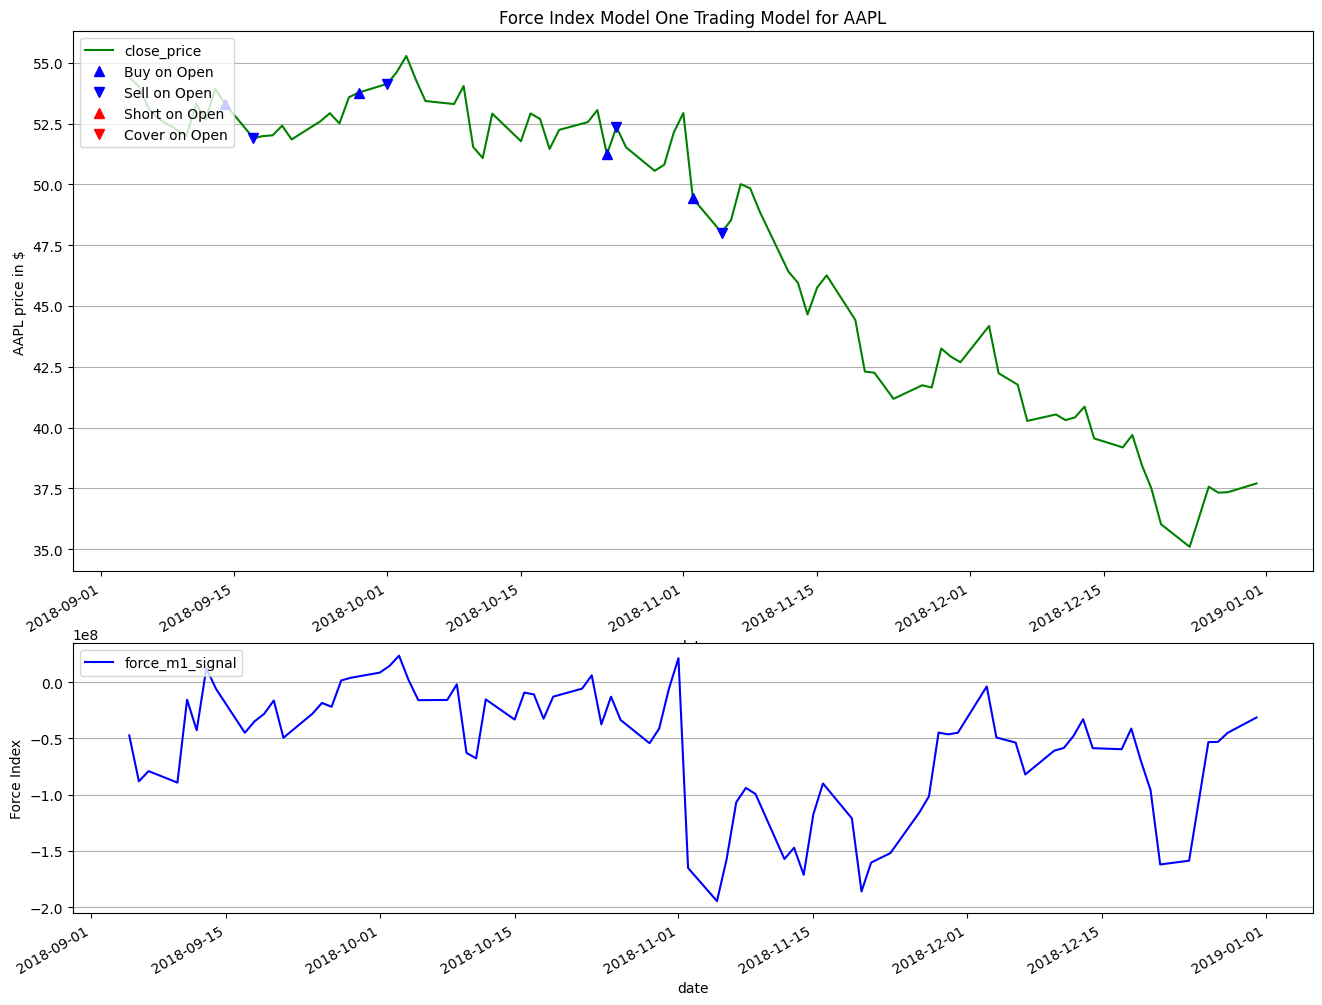

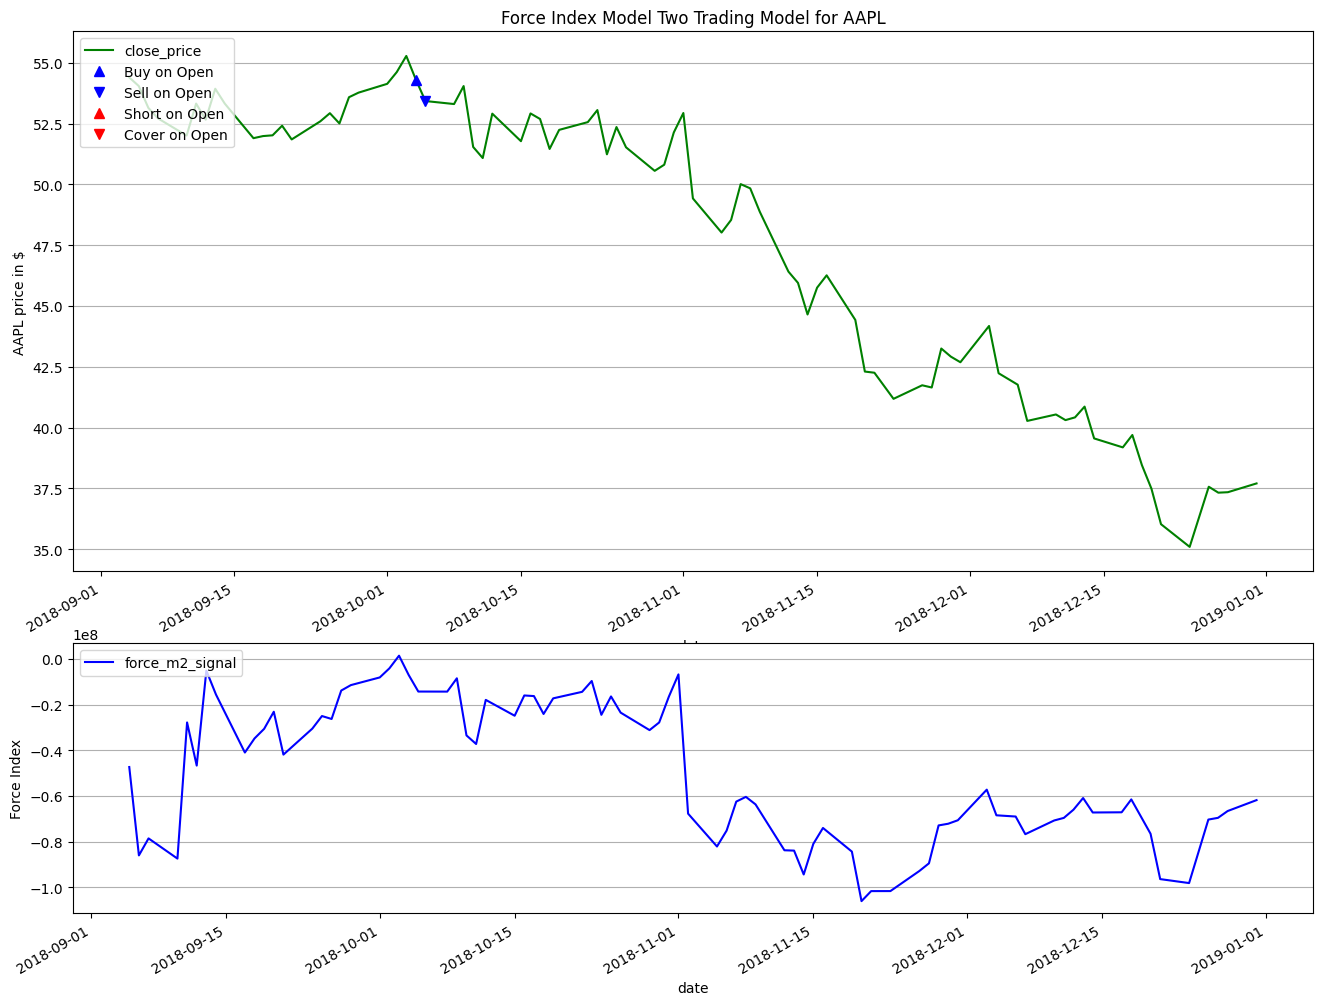

0 data points retrieved from the API call for stock: ABBV
No data retrieved for ABBV.
The DataFrame for ABBV is empty. Skipping this symbol.
0 data points retrieved from the API call for stock: AMD
No data retrieved for AMD.
The DataFrame for AMD is empty. Skipping this symbol.
0 data points retrieved from the API call for stock: AMZN
No data retrieved for AMZN.
The DataFrame for AMZN is empty. Skipping this symbol.
82 data points retrieved from the API call for stock: BA
            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-09-04    330.4291    334.9947   328.1849     334.9270    2699141.0000
2018-09-05    334.4628    335.8944   331.9381     335.3430    2958965.0000
2018-09-06    336.1846    341.7950   335.2464     339.7830    3585360.0000
2018-09-07    337.4130    338.5641   333.1956     337.8580    3921189.0000
2018-09-10    338.0605    339.2793   330.5059     330.6800    3064126.000

<ipython-input-62-9575dab3b2de>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
<ipython-input-62-9575dab3b2de>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
<ipython-input-62-9575dab3b2de>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

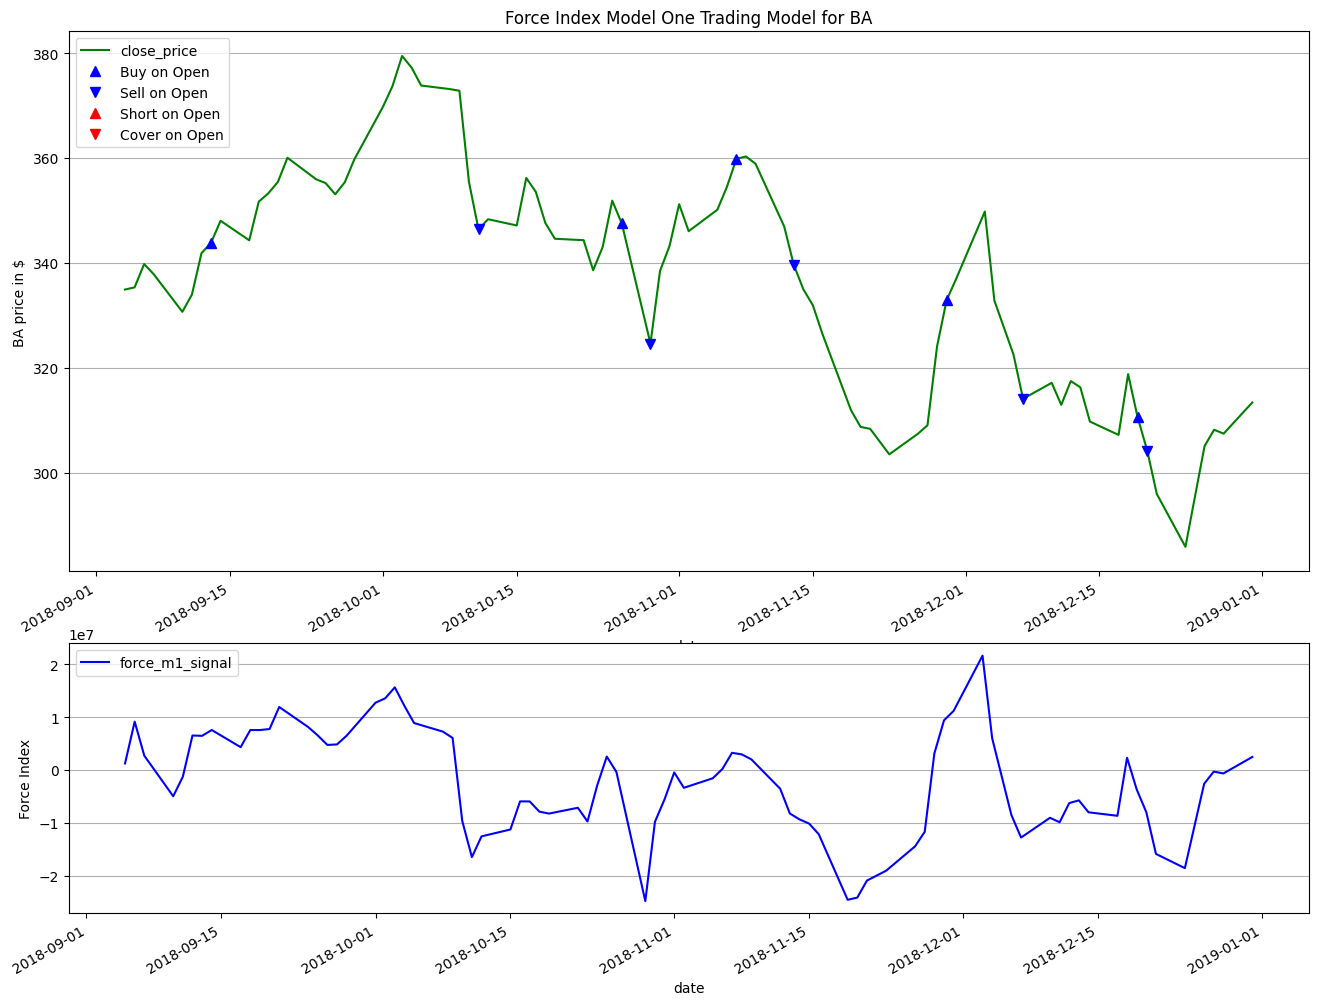

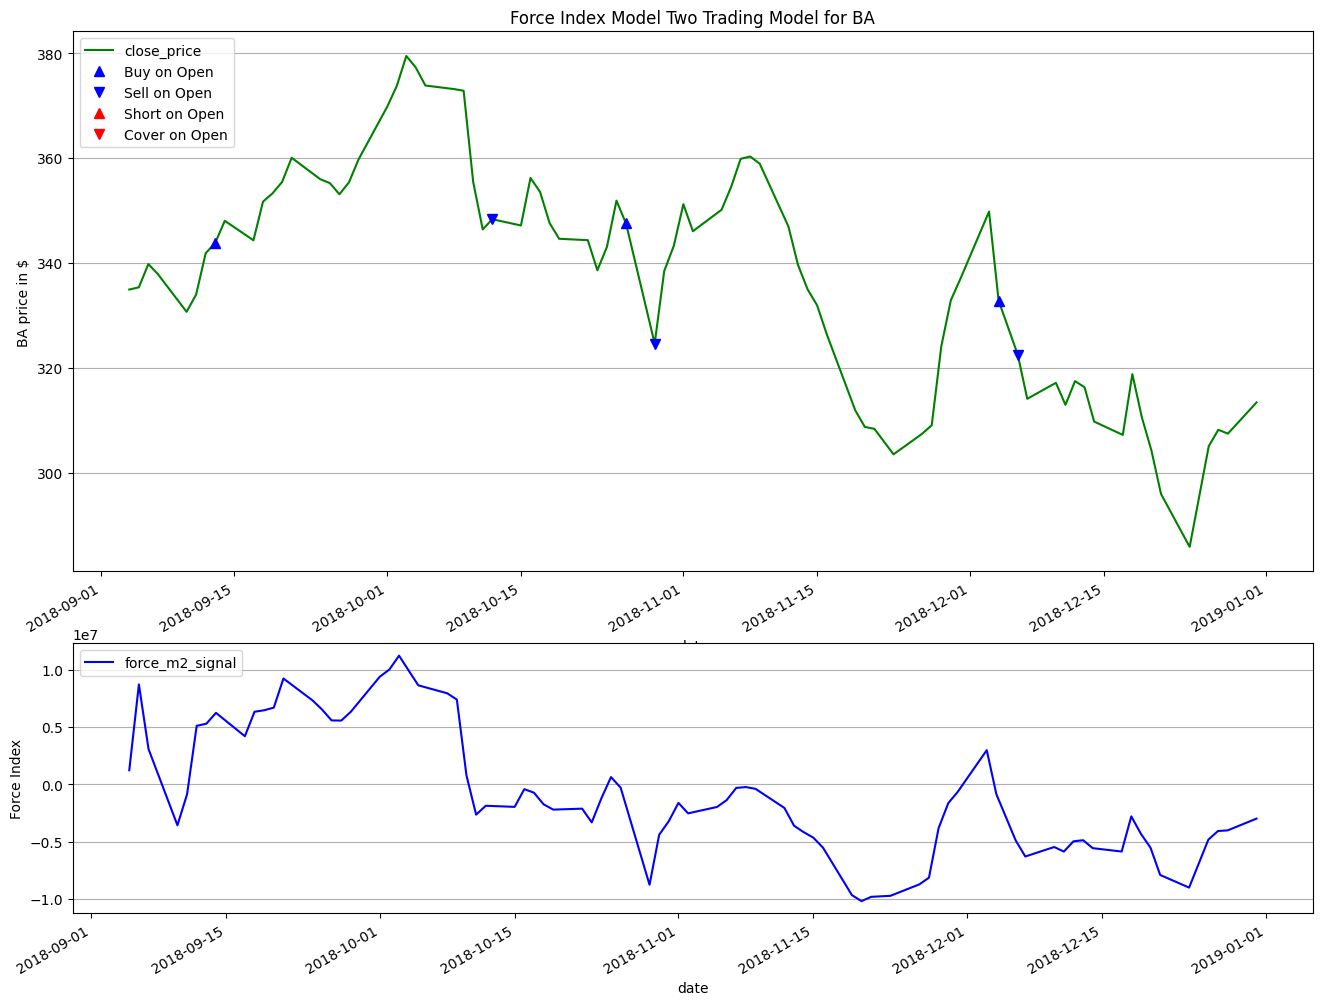

82 data points retrieved from the API call for stock: DIS
            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-09-04    109.5882    109.7842   108.4610     108.6570    6390420.0000
2018-09-05    108.3930    108.6282   107.5304     107.6970    6388319.0000
2018-09-06    107.8241    108.2260   107.1968     108.0790    5267172.0000
2018-09-07    107.9026    109.1475   107.8340     108.7750    4754801.0000
2018-09-10    109.2360    109.6937   108.1871     108.4910    4636528.0000

            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-12-24    101.9832    102.6451    99.1380      99.1380    7132955.0000
2018-12-26     99.2765    104.5718    99.1678     104.5520    9422844.0000
2018-12-27    103.1485    105.2626   101.5530     105.2330    8201369.0000
2018-12-28    105.9842    107.2093   104.

<ipython-input-62-9575dab3b2de>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
<ipython-input-62-9575dab3b2de>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
<ipython-input-62-9575dab3b2de>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

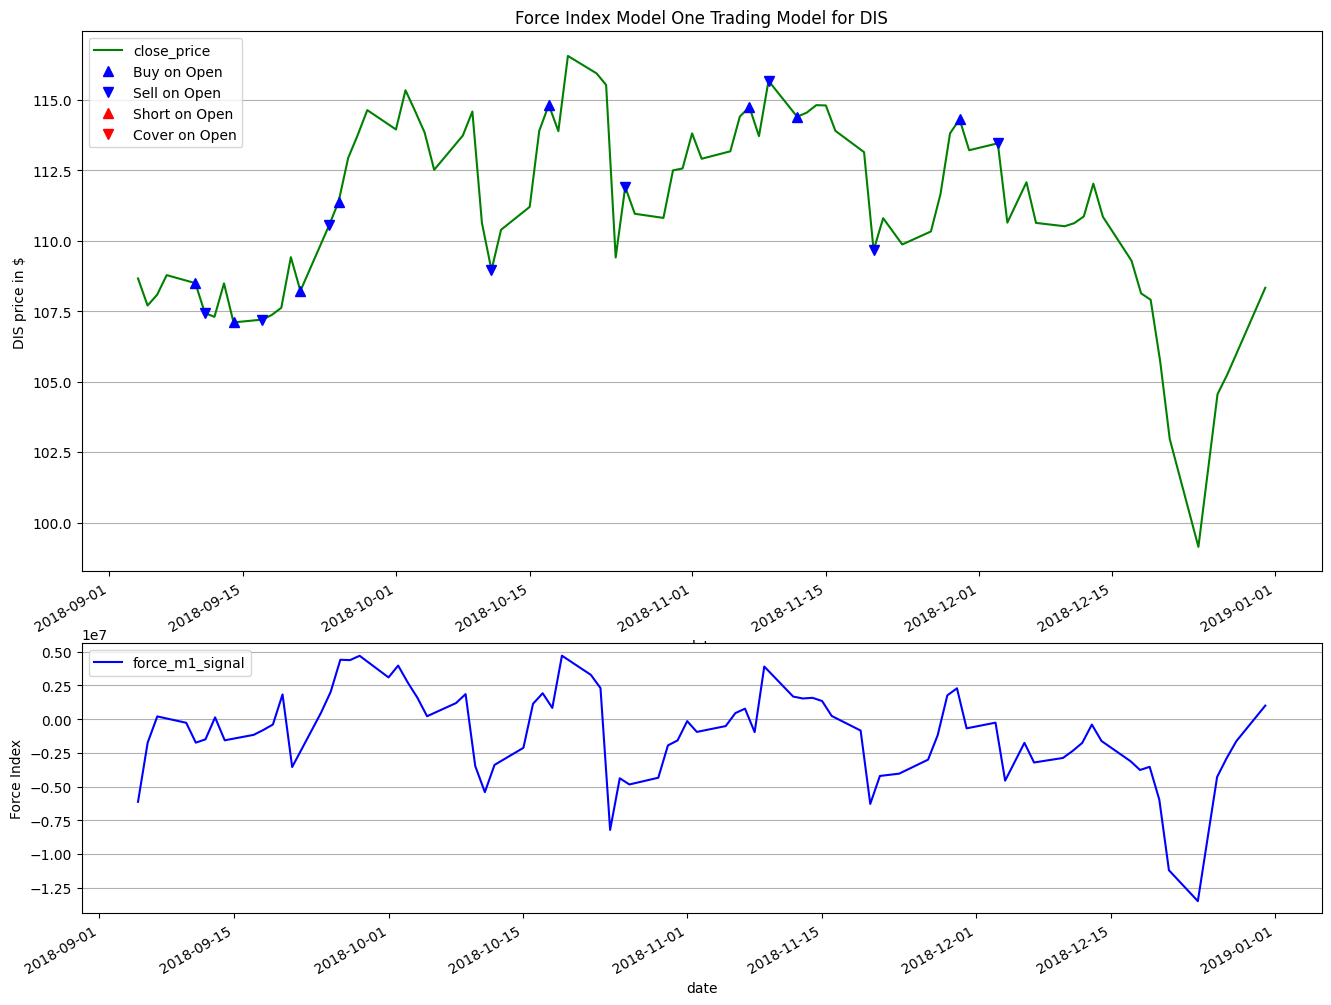

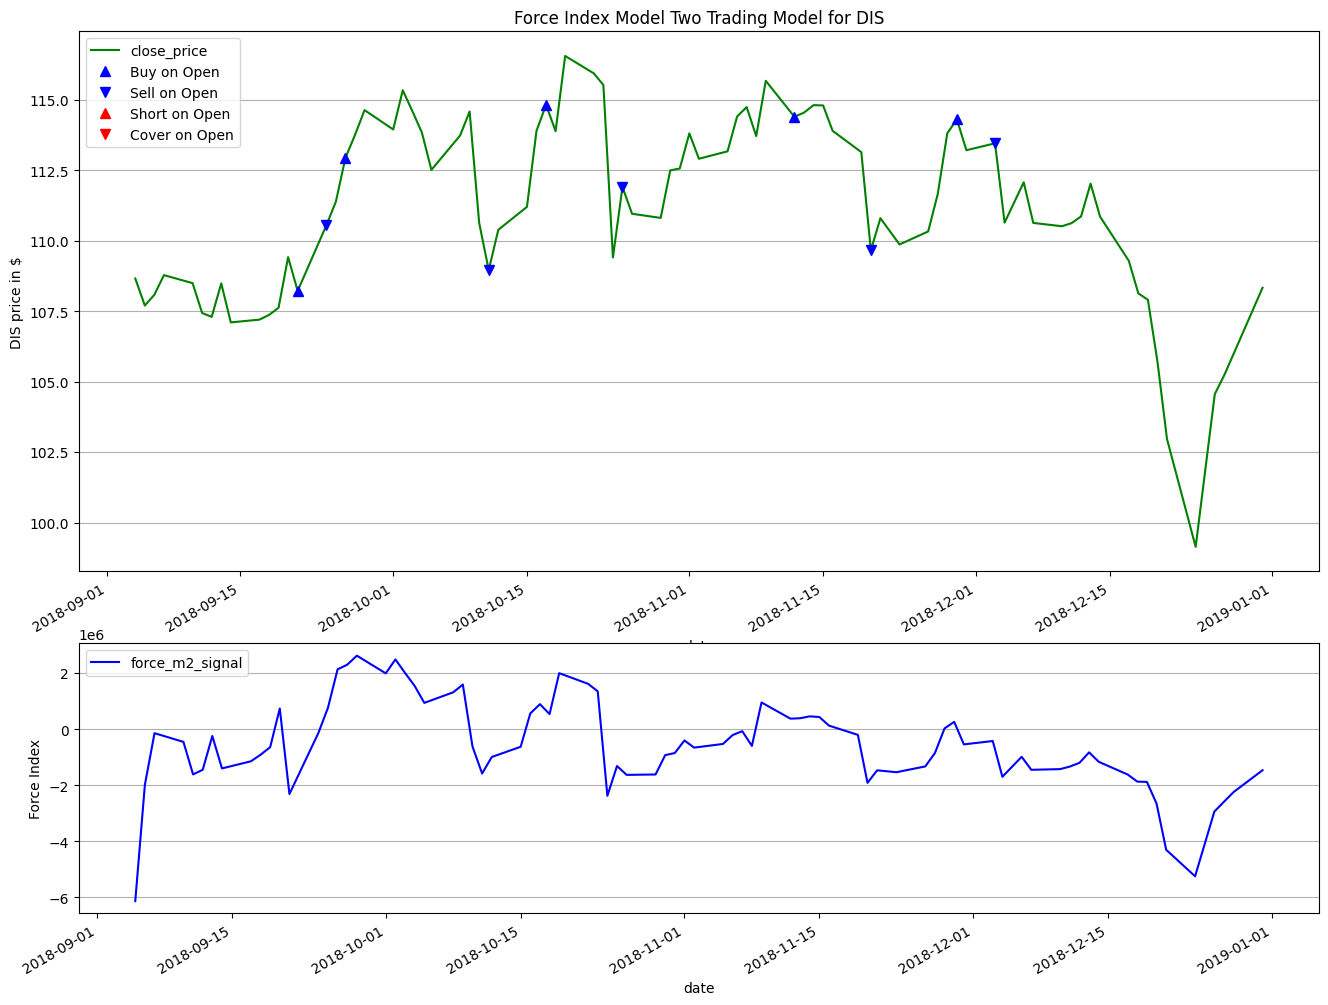

0 data points retrieved from the API call for stock: NFLX
No data retrieved for NFLX.
The DataFrame for NFLX is empty. Skipping this symbol.
0 data points retrieved from the API call for stock: GOOGL
No data retrieved for GOOGL.
The DataFrame for GOOGL is empty. Skipping this symbol.
82 data points retrieved from the API call for stock: JPM
            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-09-04     95.8321     96.5864    95.2370      96.5110   10169902.0000
2018-09-05     96.3856     96.9723    95.7570      96.0420   11461360.0000
2018-09-06     95.9663     96.1339    95.1281      95.6310    9877592.0000
2018-09-07     95.9659     96.1922    95.2367      95.8150   10954658.0000
2018-09-10     96.2595     96.3600    95.2621      95.3040    8276789.0000

            open_price  high_price  low_price  close_price  trading_volume
date                                                    

<ipython-input-62-9575dab3b2de>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
<ipython-input-62-9575dab3b2de>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
<ipython-input-62-9575dab3b2de>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

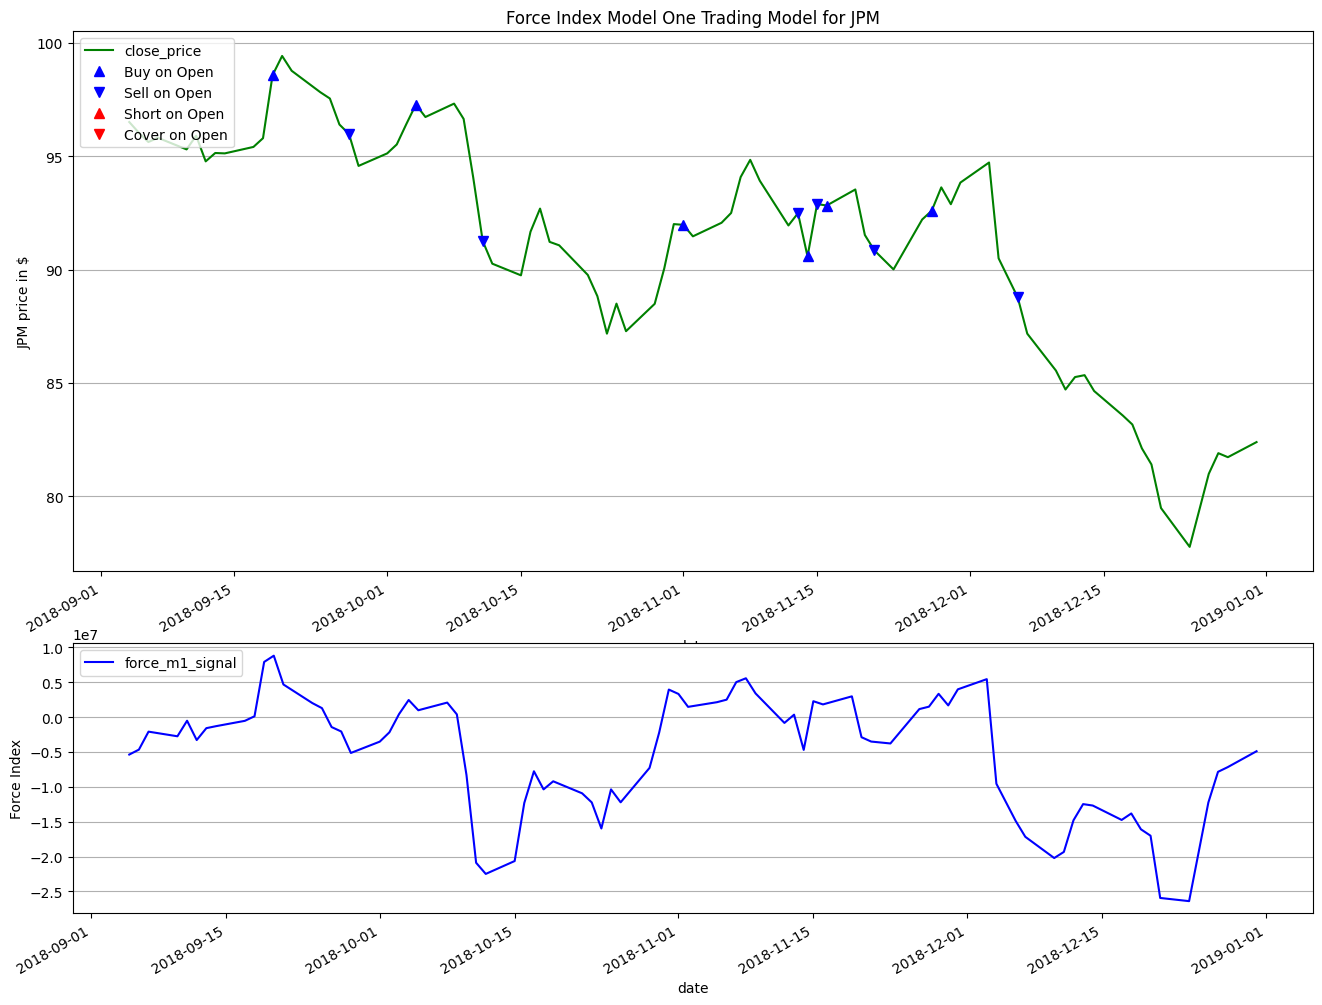

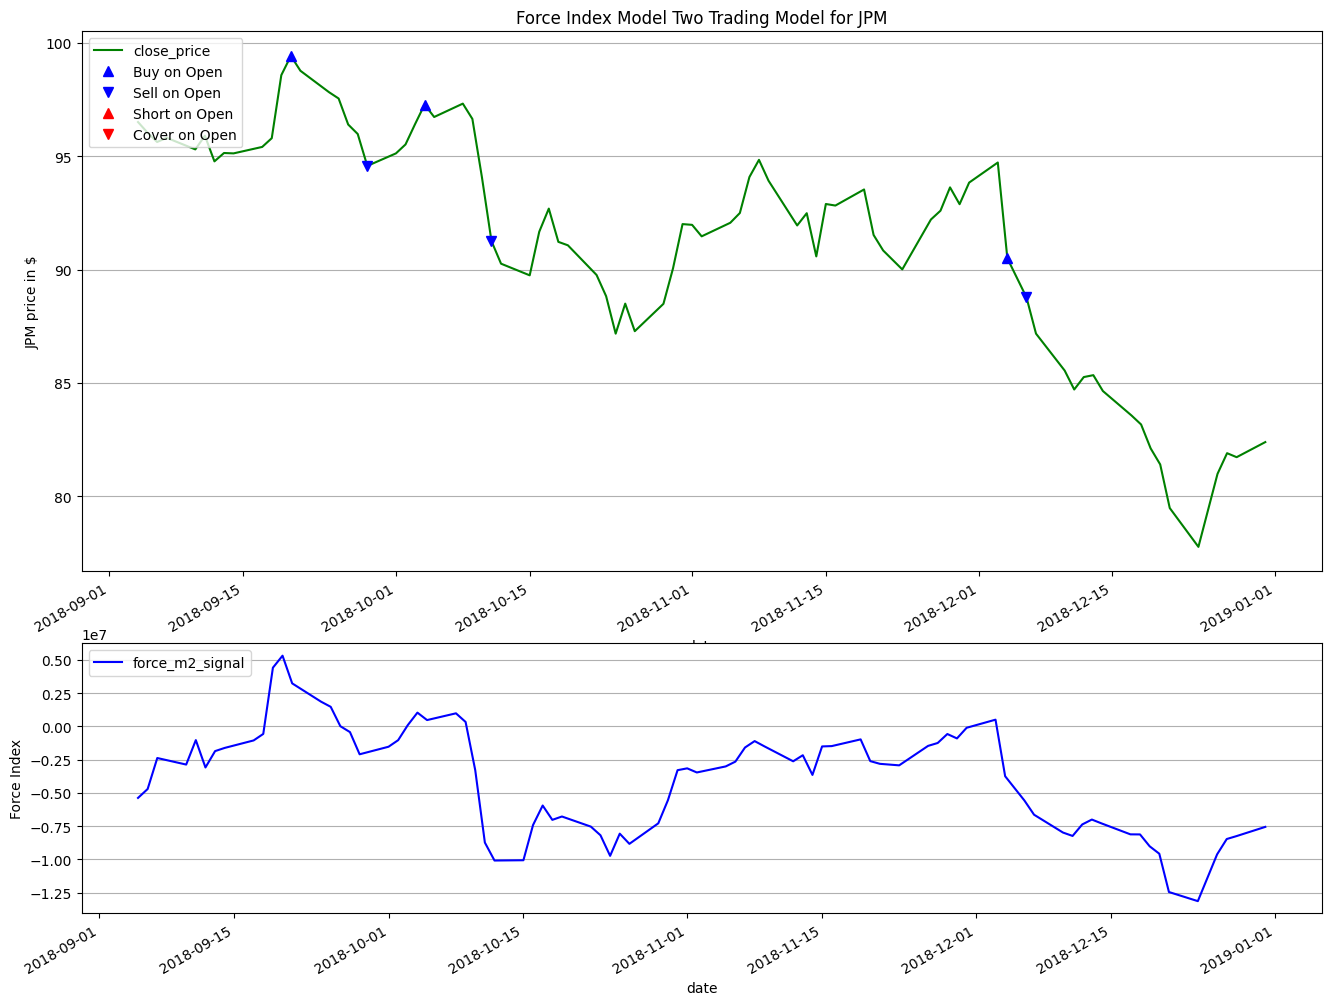

82 data points retrieved from the API call for stock: MSFT
            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-09-04    104.4060    105.4468   103.8126     105.2160   22634641.0000
2018-09-05    104.5575    104.9437   101.8167     102.1840   32872352.0000
2018-09-06    101.9575    102.6545   101.2605     102.4190   23477624.0000
2018-09-07    101.9388    102.4051   100.9970     101.9200   22498646.0000
2018-09-10    102.5134    103.2669   102.0613     103.0220   20727906.0000

            open_price  high_price  low_price  close_price  trading_volume
date                                                                      
2018-12-24     92.4053     92.6796    88.9051      89.0470   43935192.0000
2018-12-26     90.0027     95.2530    88.8864      95.1300   51634793.0000
2018-12-27     93.9375     95.7255    91.1941      95.7160   49498509.0000
2018-12-28     96.5772     96.8799    94

<ipython-input-62-9575dab3b2de>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
<ipython-input-62-9575dab3b2de>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
<ipython-input-62-9575dab3b2de>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

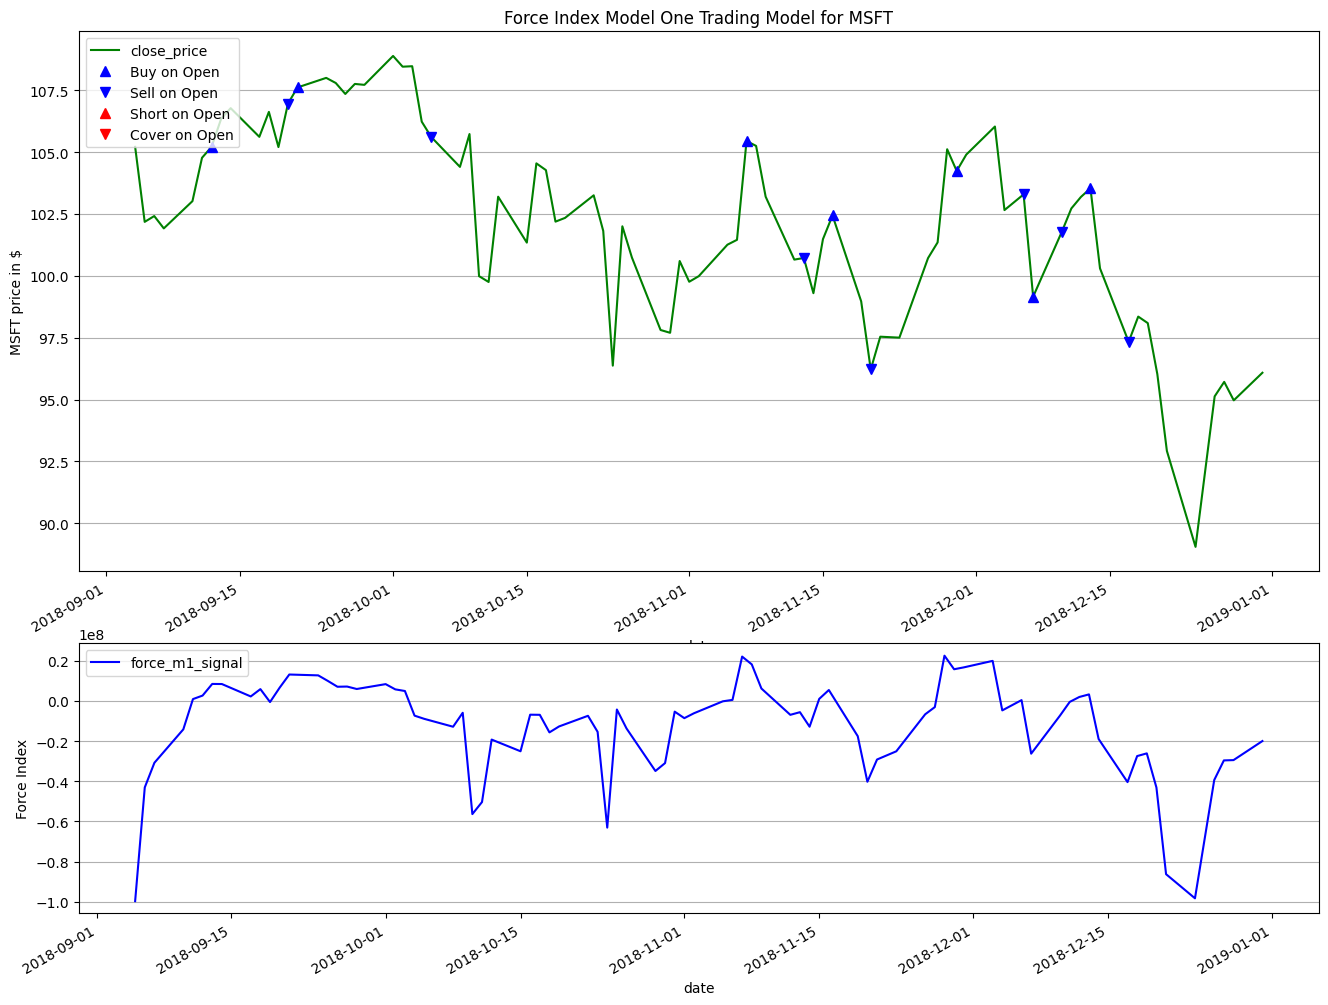

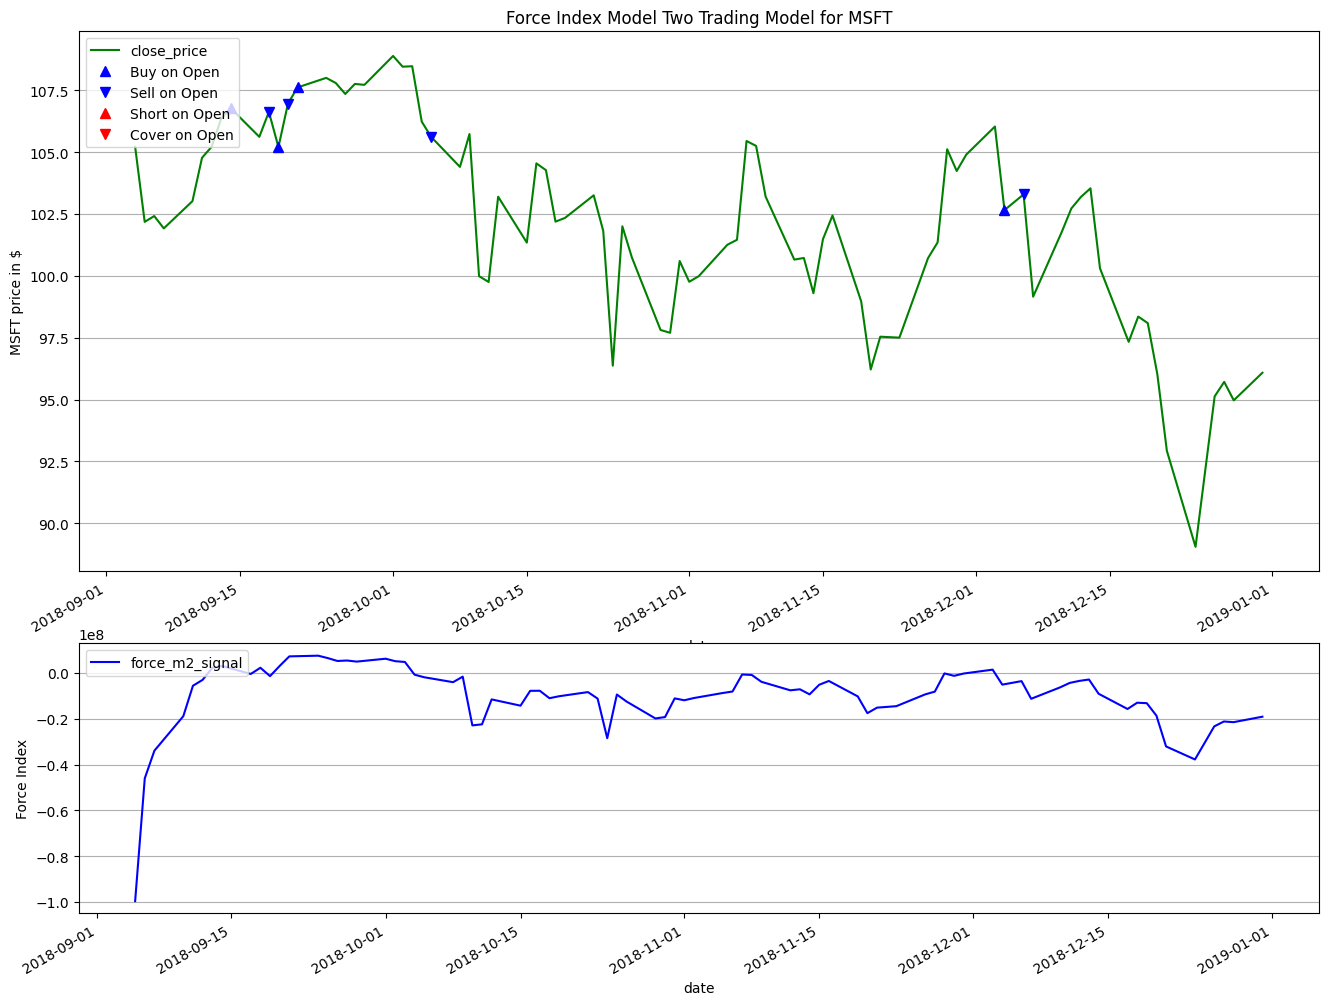

In [ ]:
for symbol in stock_list:
    stock_signals_positions = {}
    stock_model_template = retrieve_stock_data(symbol)

    if stock_model_template.empty:
        print(f'The DataFrame for {symbol} is empty. Skipping this symbol.')
        continue

    model_with_indicators = populate_indicators(stock_model_template)

    print('\nGenerating the trading signals for model #1...')
    tag_name = symbol + 'model1_signals'
    stock_signals_positions[tag_name] = populate_signals_model1(model_with_indicators)

    print('\nGenerating the trading signals for model #2...')
    tag_name = symbol + 'model2_signals'
    stock_signals_positions[tag_name] = populate_signals_model2(model_with_indicators)

    if not stock_signals_positions[tag_name].empty:
        INITIAL_CAPITAL = stock_signals_positions[tag_name].at[stock_signals_positions[tag_name].index[0], 'open_price']
        performance_values = evaluate_strategy_performance(symbol)
        performance_summary = pd.concat([performance_summary, pd.DataFrame([performance_values])], ignore_index=True)
    else:
        print(f'The DataFrame for {tag_name} is empty. Skipping performance evaluation.')

In [ ]:
print(performance_summary)

  Symbol  Buy_Hold_Return  BH_Return_PCT  Model1_Return_VAL  Model1_Return_PCT  Model1_MAX_Drawdown  Model2_Return_VAL  Model2_Return_PCT  Model2_MAX_Drawdown
0   AAPL          -4.1283       -30.3503            -0.6304            -4.6344               0.0013            -0.1678            -1.2340              -0.1410
1   AAPL          -4.1283       -30.3503            -0.6304            -4.6344               0.0013            -0.1678            -1.2340              -0.1410
2   AAPL          -4.1283       -30.3503            -0.6304            -4.6344               0.0013            -0.1678            -1.2340              -0.1410
3   AAPL          -4.1283       -30.3503            -0.6304            -4.6344               0.0013            -0.1678            -1.2340              -0.1410
4     BA         -18.9806        -5.7442           -24.7360            -7.4860             -18.4856           -17.0576            -5.1622             -14.2775
5    DIS          -1.7957        -1.6386      

In [ ]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:45:28.492603
